In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import rankdata

In [2]:
# spider trap avoidance factor
beta = 0.85

In [3]:
# start from 1st week utils.py file

import matplotlib.pyplot as plt
import IPython
from IPython.display import SVG
from IPython.display import HTML
from IPython.display import display
import networkx as nx
import StringIO
from networkx.drawing.nx_pydot import read_dot
from networkx.drawing.nx_pydot import from_pydot
from networkx.drawing.nx_agraph import to_agraph
import pydot

def toGraph(g):
    G = nx.Graph()
    for n in g:
        for n2 in g[n]:
            G.add_edge(n,n2)
    return G

def fromDot(s):
  P_list = pydot.graph_from_dot_data(s)
  return from_pydot(P_list[0])

def nM(d):
    '''Generate node labeler from dictionary''' 
    def m(n, N):
        if n in d:
            N.attr['label'] = n + ' ' + str(d[n])
    return m
def eM(d):
    '''Generate edge labeler from dictionary''' 
    def m(e, E):
        if e in d:
            E.attr['label'] = str(d[e])
    return m

def draw(G, mapping=None, emapping=None):
    '''draw graph with node mapping and emapping''' 
    A=to_agraph(G)
    A.graph_attr['overlap']='False'
    if mapping:
        if isinstance(mapping, dict):
            mapping = nM(mapping)
        for n in A.nodes():
            mapping(n, A.get_node(n))
    if emapping:
        if isinstance(emapping, dict):
            emapping = eM(emapping)
        for e in A.edges():
            emapping(e, A.get_edge(e[0],e[1]))
    A.layout()
    output = StringIO.StringIO()
    A.draw(output, format='svg')
    return SVG(data=output.getvalue())

# end from 1st week utils.py file

In [4]:

# generates a matrix from a graph 
# matrix can be a float matrix for PageRank, or a 0,1 matrix for HITS when hts=true
# returns a matrix, together with a dictionary which maps each axis index onto a node
def setup_matrix_with_graph(graph, hts=False):
    axis_len = len(graph.nodes())
    matrix = np.zeros((axis_len, axis_len))
    # matrix = np.matrix(matrix)

    nodes_dict = {}
    inverted_dict = {}
    number = 0
    # first assign each node a number 
    for node in sorted(graph.nodes()):
        nodes_dict[node] = number
        inverted_dict[number] = node
        number += 1
    # then setup matrix with those numbers as x or y
    for x_node in graph.nodes():
        x_number = nodes_dict[x_node]
        number_neighbours = len(graph[x_node])
        if number_neighbours == 0:
            if not hts:
                # make circular to avoid spider traps
                matrix.put((x_number*axis_len + x_number), 1)
        else:
            out_probability = float(1)/number_neighbours
            for y_node in graph[x_node]:
                y_number = nodes_dict[y_node]
                if hts:
                    matrix.put((y_number*axis_len + x_number), 1)
                else:
                    matrix.put((y_number*axis_len + x_number), out_probability)
                    
    # PageRank matrix goes from x to y
    # HITS matrix goes from y to x
    # However, matrix is always made from x to y
    # So, if hts=true, then transpose the matrix to get the correct result matrix
    if hts:
        matrix = np.transpose(matrix)

    return matrix, nodes_dict

In [5]:
def converge_first(matrix, b):
    matrix_size = len(matrix)

    vertex = np.full((matrix_size, 1), float(1)/matrix_size)
    # vertex = np.matrix(vertex)
    
    first = np.dot(matrix, vertex)
    first = np.multiply(b, first)
    second = np.multiply(1-b, vertex)

    result = np.add(first, second)
    return result

def converge(matrix, b, vertex):
    matrix_size = len(matrix)
    one_div_n = float(1)/matrix_size
    
    first1 = np.dot(matrix, vertex)
    first2 = np.multiply(b, first1)
    second = np.multiply(1-b, one_div_n)

    result = np.add(first2, second)
    return result

def normalize(matrix):
    maximum = matrix.max()
    result = np.divide(matrix, maximum)
    return result

# get hubs and authorities from hubs and a matrix with a given hub
def converge_hits(matrix, h):
    matrix_t = np.transpose(matrix)
    
    mth = np.dot(matrix_t, h)
    a = normalize(mth)
    
    ma = np.dot(matrix, a)
    h = normalize(ma)
    return h,a

# get hubs and authorities from hubs and a matrix
def converge_hits_first(matrix):
    matrix_size = len(matrix)
    
    h = np.ones((matrix_size, 1))
    matrix_t = np.transpose(matrix)
    mth = np.dot(matrix_t, h)
    a = normalize(mth)
    
    ma = np.dot(matrix, a)
    h = normalize(ma)
    
    return h,a

In [6]:
def run_test():
    b = 1
    test_matrix = np.matrix([[0, float(1)/2, 0, 0], 
                        [float(1)/3, 0, 0, float(1)/2], 
                        [float(1)/3, 0, 1, float(1)/2], 
                        [float(1)/3, float(1)/2, 0, 0]])
    print(test_matrix)
    
    old_result = converge_first(test_matrix, b)
    result = converge(test_matrix, b, old_result)
    print("first calculation: ", result)
    
    while not np.array_equal(result, old_result):
        old_result = result
        result = converge(test_matrix, b, old_result)

    return result

def run_program(b = 1):
    matrix = setup_matrix()
    old_result = converge_first(matrix, b)
    result = converge(matrix, b, old_result)
    while not np.array_equal(result, old_result):
        old_result = result
        result = converge(matrix, 1, old_result)

    return result
        
def run_program_with_matrix(m, b=1):
    old_result = converge_first(m, b)
    result = converge(m, b, old_result)
    
    # use around to round to two decimals, as to not loop indefinitely for some graphs
    while not np.array_equal(np.around(result, 2), np.around(old_result, 2)):
        old_result = result
        result = converge(m, b, old_result)

    return result
      
def run_hits_with_matrix(m):
    h, a = converge_hits_first(m)
    old_h = None
    
    while not np.array_equal(h, old_h):
        old_h = h
        h, a = converge_hits(m, old_h)

    return h, a

def run_indegree_with_matrix(m):
    ones = np.ones((len(m), 1))
    result = np.dot(m, ones)
    return result

In [7]:
print("converged result: ", run_test())
print("should have printed approximately:", [[0]
                                            ,[0]
                                            ,[1]
                                            ,[0]])

[[0.         0.5        0.         0.        ]
 [0.33333333 0.         0.         0.5       ]
 [0.33333333 0.         1.         0.5       ]
 [0.33333333 0.5        0.         0.        ]]
('first calculation: ', matrix([[0.10416667],
        [0.14583333],
        [0.60416667],
        [0.14583333]]))
('converged result: ', matrix([[0.],
        [0.],
        [1.],
        [0.]]))
('should have printed approximately:', [[0], [0], [1], [0]])


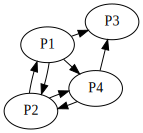

{'P2': 1, 'P3': 2, 'P1': 0, 'P4': 3}
[[0.         0.5        0.         0.        ]
 [0.33333333 0.         0.         0.5       ]
 [0.33333333 0.         1.         0.5       ]
 [0.33333333 0.5        0.         0.        ]]
[[0.00226562]
 [0.00330198]
 [0.99113043]
 [0.00330198]]


In [8]:
slides1 = fromDot('''digraph A {
    P1 -> P2;
    P1 -> P3;
    P1 -> P4;
    P2 -> P1;
    P2 -> P4;
    P4 -> P2;
    P4 -> P3;
}   
''')

display(draw(slides1))

matrix1, nodes = setup_matrix_with_graph(slides1)
print(nodes)
print(matrix1)
print(run_program_with_matrix(matrix1))

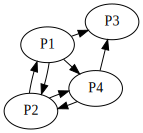

{'P2': 1, 'P3': 2, 'P1': 0, 'P4': 3}
[[0.         0.5        0.         0.        ]
 [0.33333333 0.         0.         0.5       ]
 [0.33333333 0.         1.         0.5       ]
 [0.33333333 0.5        0.         0.        ]]
[[0.10212147]
 [0.12950079]
 [0.63887694]
 [0.12950079]]


In [9]:
slides2 = fromDot('''digraph A {
    P1 -> P2;
    P1 -> P3;
    P1 -> P4;
    P2 -> P1;
    P2 -> P4;
    P4 -> P2;
    P4 -> P3;
}   
''')

display(draw(slides2))

matrix2, nodes = setup_matrix_with_graph(slides2)
print(nodes)
print(matrix2)
print(run_program_with_matrix(matrix2, 0.8))

In [10]:
slides3 = fromDot('''digraph A {
    P1 -> P2;
    P1 -> P3;
    P1 -> P4;
    P2 -> P1;
    P2 -> P4;
    P3 -> P5;
    P4 -> P2;
    P4 -> P3;
}   
''')

matrix3, nodes = setup_matrix_with_graph(slides3, True)
print(nodes)
print(matrix3)
h3, a3 = run_hits_with_matrix(matrix3)
print("\nh: ")
print h3
print("\na: ")
print a3

{'P2': 1, 'P3': 2, 'P1': 0, 'P4': 3, 'P5': 4}
[[0. 1. 1. 1. 0.]
 [1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]

h: 
[[1.        ]
 [0.35825757]
 [0.        ]
 [0.71651514]
 [0.        ]]

a: 
[[0.20871215]
 [1.        ]
 [1.        ]
 [0.79128785]
 [0.        ]]



# Exercise 3

**NOTE:** for some graphs, the calculations would run (almost?) infinitely, which is why the code stops converging if the
output is the same up to and including the second decimal.
Because of this, there might be small errors in the results, for instance 0.9934 where 1 was expected.

In [11]:
def run_exercise3_p1():
    
    graph1 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> p1;
        n2 -> n1;
        n2 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> t1;
        t1 -> f1;
        f1 -> t1;
    } ''')
    
    graph2 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> p1;
        n2 -> n1;
        n2 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')
    
    graph3 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> p1;
        n2 -> n1;
        n2 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        t1 -> f3;
        f1 -> t1;
        f2 -> t1;
        f3 -> t1;
    } ''')
    
    graph4 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> p1;
        n2 -> n1;
        n2 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        t1 -> f3;
        t1 -> f4;
        f1 -> t1;
        f2 -> t1;
        f3 -> t1;
        f4 -> t1;
    } ''')
    
    graph5 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> p1;
        n2 -> n1;
        n2 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        t1 -> f3;
        t1 -> f4;
        t1 -> f5;
        t1 -> f6;
        f1 -> t1;
        f2 -> t1;
        f3 -> t1;
        f4 -> t1;
        f5 -> t1;
        f6 -> t1;
    } ''')
    
    graph6 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> p1;
        n2 -> n1;
        n2 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        t1 -> f3;
        t1 -> f4;
        t1 -> f5;
        t1 -> f6;
        t1 -> f7;
        t1 -> f8;
        t1 -> f9;
        f1 -> t1;
        f2 -> t1;
        f3 -> t1;
        f4 -> t1;
        f5 -> t1;
        f6 -> t1;
        f7 -> t1;
        f8 -> t1;
        f9 -> t1;
    } ''')
    
    
    graphs = [graph1, graph2, graph3, graph4, graph5, graph6]
    
    array_f = []
    array_t = []
    
    for graph in graphs:
        # display(draw(graph))
        graph_matrix, graph_nodes = setup_matrix_with_graph(graph)
        result = run_program_with_matrix(graph_matrix, beta)
        # print(graph_nodes)
        # print(result)
        
        f_count = 0
        for name in graph_nodes.keys():
            if 'f' in name:
                f_count += 1
            elif name == "t1":
                index = graph_nodes[name]
                array_t.append(result[index, 0])
        array_f.append(f_count)
    
    # print(array_t)
    # print(array_f)
    plt.plot(array_f, array_t, 'o')
    plt.xlabel("number of supporting pages f")
    plt.ylabel("PageRank of T")
    plt.figtext(0,-0.05,"Figure 1: the PageRank of site T, as a function of the number of supporting pages f")
    plt.show()

In [12]:
def run_exercise3_p2():
    
    graph1 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> n3;
        n1 -> n4;
        n1 -> p1;
        n2 -> n1;
        n2 -> n3;
        n2 -> n4;
        n2 -> p1;
        n3 -> n1;
        n3 -> n2;
        n3 -> n4;
        n3 -> p1;
        n4 -> n1;
        n4 -> n2;
        n4 -> n3;
        n4 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> n3;
        p1 -> n4;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')
    
    graph2 = fromDot('''digraph A {
        n1 -> n3;
        n1 -> n4;
        n1 -> p1;
        n2 -> n3;
        n2 -> n4;
        n2 -> p1;
        n3 -> n1;
        n3 -> n2;
        n3 -> p1;
        n4 -> n1;
        n4 -> n2;
        n4 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> n3;
        p1 -> n4;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')
    
    graph3 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> n3;
        n1 -> n4;
        n1 -> p1;
        n2 -> n1;
        n2 -> n3;
        n2 -> n4;
        n2 -> p1;
        n3 -> n1;
        n3 -> n2;
        n3 -> n4;
        n3 -> p1;
        n4 -> n1;
        n4 -> n2;
        n4 -> n3;
        n4 -> p1;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')
    
    graph4 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> n3;
        n1 -> n4;
        n1 -> p1;
        n2 -> n1;
        n2 -> n3;
        n2 -> n4;
        n3 -> n1;
        n3 -> n2;
        n3 -> n4;
        n4 -> n1;
        n4 -> n2;
        n4 -> n3;
        p1 -> n1;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')
    
    graph5 = fromDot('''digraph A {
        n1 -> n2;
        n2 -> n3;
        n3 -> n4;
        n4 -> n1;
        n4 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> n3;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')
    
    graph6 = fromDot('''digraph A {
        n1 -> n2;
        n2 -> n1;
        n2 -> n3;
        n2 -> n4;
        n3 -> n1;
        n3 -> n2;
        n3 -> p1;
        n4 -> n1;
        n4 -> n3;
        n4 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')
    
    graphs = [graph1, graph2, graph3, graph4, graph5, graph6]
    
    array_p = []
    array_t = []
    
    for graph in graphs:
        # display(draw(graph))
        graph_matrix, graph_nodes = setup_matrix_with_graph(graph)
        result = run_program_with_matrix(graph_matrix, beta)
        # print(graph_nodes)
        # print(result)
        
        for name in graph_nodes.keys():
            if name == "p1":
                # if "p2" not in graph_nodes.keys():
                    index = graph_nodes[name]
                    array_p.append(result[index, 0])
                    
            elif name == "t1":
                index = graph_nodes[name]
                array_t.append(result[index, 0])
    
    # print(array_t)
    # print(array_p)
    plt.plot(array_p, array_t, 'o')
    plt.xlabel("external PageRank r")
    plt.ylabel("PageRank of T")
    plt.figtext(0,-0.07,"Figure 2: the PageRank of site T, as a function of external PageRank r \nwhile having only one P, with different connections between inacessible pages n")
    plt.show()

In [13]:
def run_exercise3_p3():
    
    graph1 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> n3;
        n1 -> n4;
        n1 -> p1;
        n2 -> n1;
        n2 -> n3;
        n2 -> n4;
        n2 -> p1;
        n3 -> n1;
        n3 -> n2;
        n3 -> n4;
        n3 -> p1;
        n4 -> n1;
        n4 -> n2;
        n4 -> n3;
        n4 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> n3;
        p1 -> n4;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')

    graph2 = fromDot('''digraph A {
        n1 -> n3;
        n1 -> n4;
        n1 -> p1;
        n1 -> p2;
        n2 -> n3;
        n2 -> n4;
        n2 -> p1;
        n2 -> p2;
        n3 -> n1;
        n3 -> n2;
        n3 -> p1;
        n3 -> p2;
        n4 -> n1;
        n4 -> n2;
        n4 -> p1;
        n4 -> p2;
        p1 -> n1;
        p1 -> n2;
        p1 -> n3;
        p1 -> n4;
        p1 -> t1;
        p2 -> n1;
        p2 -> n2;
        p2 -> n3;
        p2 -> n4;
        p2 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')

    graph3 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> n3;
        n1 -> n4;
        n1 -> p1;
        n1 -> p2;
        n1 -> p3;
        n2 -> n1;
        n2 -> n3;
        n2 -> n4;
        n2 -> p1;
        n2 -> p2;
        n2 -> p3;
        n3 -> n1;
        n3 -> n2;
        n3 -> n4;
        n3 -> p1;
        n3 -> p2;
        n3 -> p3;
        n4 -> n1;
        n4 -> n2;
        n4 -> n3;
        n4 -> p1;
        n4 -> p2;
        n4 -> p3;
        p1 -> t1;
        p1 -> n1;
        p1 -> n2;
        p1 -> n3;
        p1 -> n4;
        p2 -> t1;
        p2 -> n1;
        p2 -> n2;
        p2 -> n3;
        p2 -> n4;
        p3 -> t1;
        p3 -> n1;
        p3 -> n2;
        p3 -> n3;
        p3 -> n4;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')

    graph4 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> n3;
        n1 -> n4;
        n1 -> p1;
        n2 -> n1;
        n2 -> n3;
        n2 -> n4;
        n2 -> p2;
        n3 -> n1;
        n3 -> n2;
        n3 -> n4;
        n3 -> p3;
        n4 -> n1;
        n4 -> n2;
        n4 -> n3;
        n4 -> p4;
        p1 -> n1;
        p1 -> t1;
        p2 -> n2;
        p2 -> t1;
        p3 -> n3;
        p3 -> t1;
        p4 -> n4;
        p4 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')

    graph5 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> p2;
        n2 -> n3;
        n2 -> p3;
        n3 -> n4;
        n3 -> p4;
        n4 -> n1;
        n4 -> p1;
        n4 -> p5;
        p1 -> n1;
        p1 -> n2;
        p1 -> n3;
        p1 -> t1;
        p2 -> t1;
        p2 -> n2;
        p2 -> n3;
        p2 -> n4;
        p3 -> t1;
        p3 -> n3;
        p3 -> n4;
        p3 -> n1;
        p4 -> t1;
        p4 -> n4;
        p4 -> n1;
        p4 -> n2;
        p5 -> t1;
        p5 -> n1;
        p5 -> n2;
        p5 -> n3;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')

    graph6 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> p4;
        n1 -> p5;
        n1 -> p6;
        n2 -> n1;
        n2 -> n3;
        n2 -> n4;
        n2 -> p4;
        n2 -> p5;
        n2 -> p6;
        n3 -> n1;
        n3 -> n2;
        n3 -> p1;
        n3 -> p2;
        n3 -> p3;
        n4 -> n1;
        n4 -> n3;
        n4 -> p1;
        n4 -> p2;
        n4 -> p3;
        p1 -> n1;
        p1 -> n2;
        p1 -> t1;
        p2 -> n3;
        p2 -> n4;
        p2 -> t1;
        p3 -> n1;
        p3 -> n3;
        p3 -> t1;
        p4 -> n2;
        p4 -> n3;
        p4 -> t1;
        p5 -> n1;
        p5 -> n4;
        p5 -> t1;
        p6 -> n1;
        p6 -> n2;
        p6 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')

    graphs = [graph1, graph2, graph3, graph4, graph5]
    
    array_p = []
    array_t = []
    
    for graph in graphs:
        # display(draw(graph))
        graph_matrix, graph_nodes = setup_matrix_with_graph(graph)
        result = run_program_with_matrix(graph_matrix, beta)
        # print(graph_nodes)
        # print(result)
        
        total_of_p = 0
        for name in graph_nodes.keys():
            if 'p' in name:
                index = graph_nodes[name]
                total_of_p += result[index, 0]  
            elif name == "t1":
                index = graph_nodes[name]
                array_t.append(result[index, 0])
        array_p.append(beta*total_of_p)
    
    # print(array_t)
    # print(array_p)
    plt.plot(array_p, array_t, 'o')
    plt.xlabel("external PageRank r")
    plt.ylabel("PageRank of T")
    plt.figtext(0, -0.1,"Figure 3: the PageRank of site T, as a function of external PageRank r \nwhile the outlinks of each P differ between graphs. \nLinks between each n are kept the same")
    plt.show()

In [14]:
def run_exercise3_p4():
    
    graph1 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> n3;
        n1 -> n4;
        n1 -> p1;
        n2 -> n1;
        n2 -> n3;
        n2 -> n4;
        n2 -> p1;
        n3 -> n1;
        n3 -> n2;
        n3 -> n4;
        n3 -> p1;
        n4 -> n1;
        n4 -> n2;
        n4 -> n3;
        n4 -> p1;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')
    
    graph2 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> n3;
        n1 -> n4;
        n1 -> p1;
        n1 -> p2;
        n2 -> n1;
        n2 -> n3;
        n2 -> n4;
        n2 -> p1;
        n2 -> p2;
        n3 -> n1;
        n3 -> n2;
        n3 -> n4;
        n3 -> p1;
        n3 -> p2;
        n4 -> n1;
        n4 -> n2;
        n4 -> n3;
        n4 -> p1;
        n4 -> p2;
        p1 -> t1;
        p2 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')
    
    graph3 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> n3;
        n1 -> n4;
        n1 -> p1;
        n1 -> p2;
        n1 -> p3;
        n2 -> n1;
        n2 -> n3;
        n2 -> n4;
        n2 -> p1;
        n2 -> p2;
        n2 -> p3;
        n3 -> n1;
        n3 -> n2;
        n3 -> n4;
        n3 -> p1;
        n3 -> p2;
        n3 -> p3;
        n4 -> n1;
        n4 -> n2;
        n4 -> n3;
        n4 -> p1;
        n4 -> p2;
        n4 -> p3;
        p1 -> t1;
        p2 -> t1;
        p3 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')
    
    graph4 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> n3;
        n1 -> n4;
        n1 -> p1;
        n1 -> p2;
        n1 -> p3;
        n1 -> p4;
        n2 -> n1;
        n2 -> n3;
        n2 -> n4;
        n2 -> p1;
        n2 -> p2;
        n2 -> p3;
        n2 -> p4;
        n3 -> n1;
        n3 -> n2;
        n3 -> n4;
        n3 -> p1;
        n3 -> p2;
        n3 -> p3;
        n3 -> p4;
        n4 -> n1;
        n4 -> n2;
        n4 -> n3;
        n4 -> p1;
        n4 -> p2;
        n4 -> p3;
        n4 -> p4;
        p1 -> t1;
        p2 -> t1;
        p3 -> t1;
        p4 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')
    
    graph5 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> n3;
        n1 -> n4;
        n1 -> p1;
        n1 -> p2;
        n1 -> p3;
        n1 -> p4;
        n1 -> p5;
        n2 -> n1;
        n2 -> n3;
        n2 -> n4;
        n2 -> p1;
        n2 -> p2;
        n2 -> p3;
        n2 -> p4;
        n2 -> p5;
        n3 -> n1;
        n3 -> n2;
        n3 -> n4;
        n3 -> p1;
        n3 -> p2;
        n3 -> p3;
        n3 -> p4;
        n3 -> p5;
        n4 -> n1;
        n4 -> n2;
        n4 -> n3;
        n4 -> p1;
        n4 -> p2;
        n4 -> p3;
        n4 -> p4;
        n4 -> p5;
        p1 -> t1;
        p2 -> t1;
        p3 -> t1;
        p4 -> t1;
        p5 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    } ''')
    
    graphs = [graph1, graph2, graph3, graph4, graph5]
    
    array_p = []
    array_t = []
    
    for graph in graphs:
        # display(draw(graph))
        graph_matrix, graph_nodes = setup_matrix_with_graph(graph)
        result = run_program_with_matrix(graph_matrix, beta)
        # print(graph_nodes)
        # print(result)
        
        total_of_p = 0
        for name in graph_nodes.keys():
            if 'p' in name:
                index = graph_nodes[name]
                total_of_p += result[index, 0]  
            elif name == "t1":
                index = graph_nodes[name]
                array_t.append(result[index, 0])
        array_p.append(beta*total_of_p)
    
    # print(array_t)
    # print(array_p)
    plt.plot(array_p, array_t, 'o')
    plt.xlabel("external PageRank r")
    plt.ylabel("PageRank of T")
    plt.figtext(0, -0.1,"Figure 4: the PageRank of site T, as a function of external PageRank r \nwhile having different numbers of P with each P only having one out link, namely to T. \nLinks between each n are kept the same")
    plt.show()

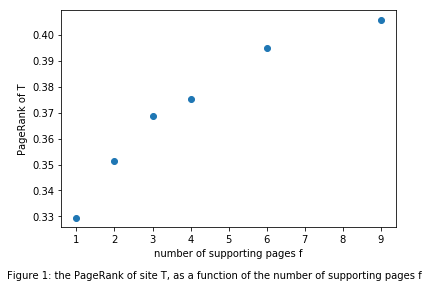

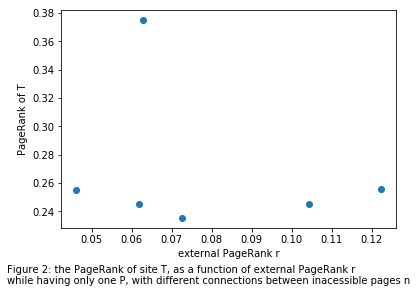

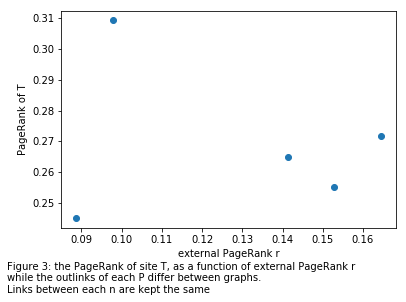

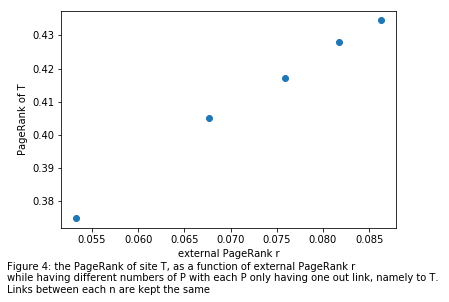

In [15]:
def run_exercise3():
    run_exercise3_p1()
    print("\n")
    run_exercise3_p2()
    print("\n")
    run_exercise3_p3()
    print("\n")
    run_exercise3_p4()
    
run_exercise3()

**Results**

**From Figure 1:** It seems that experimental results show that a higher amount of support pages f indeed give page T a higher PageRank score. The increase in PageRank score does not seem to be linear however, but this might also have to do with the increase in the total amount of nodes in the graph.

**From Figure 2:** It seems that experimental results show that a higher external PageRank r, does not correlate to the PageRank score for page T if there is only one P, and connections between inaccessible pages n differ.

**From Figure 3:** It seems that experimental results show that a higher external PageRank r, does not correlate to the PageRank score for page T if there are multiple accessible pages P, but each P has multple (different) outgoing links to inaccessible pages n.

**From Figure 4:** It seems that experimental results show that a higher external PageRank r, does cause an increase in the PageRank score for page T if each page P only has one outgoing link, namely to page T, and connections between inaccessible pages n are kept the same.

_________________________

**Mathematical proof**

For the first calculation round, the matrix is multiplied with a vector that is 1/total_nodes.
As for PageRank, it goes from x to y, so that means that the result vector has a higher PageRank for the nodes with lots of inward connections, and those inward connection have a high probability of happening from the originating nodes.
For the following rounds, the matrix is multiplied with that vector, which means that it calculates the probability of ending up at node y from an incoming connection from node x, where x already has the probability of the previous calculation. So for the node x that has a high PageRank in the previous calculation, and have an outgoing link to node y, then y will receive a high rank.
That calculation then repeats itself until convergeance of the PageRanks.
The beta will only smoothen this behaviour a bit, as it gives a chance of "teleportation" to a random node.

This means that with a higher number of supporting pages f, there are lots of incoming links to page T, which gives T a high PageRank in the first calculation.
In the then following calculations, the page T only has outgoing links to the supporting pages f, so only the PageRank for pages f will increase with the relatively high PageRank of T. Then that high pagerank for each f will again increase the PageRank for page T, as each f only has an outgoing link to page T.
So this is a mathematical proof that an increase in supporting pages f will indeed increase the PageRank for page T. (As seen in Figure 1)

For the external PageRank r (r = beta * sum of PageRank of pages P), the picture is not so clear, as there could be a difference in how the P is connected to the inaccessible pages n. 
This means that the external pagerank r does nog have a direct correlation to an increase of the PageRank of T, as it also depend on how many outgoing links each P has. If the link to page T is only one of the many outgoing connections, then the influence on page T is minimal, even if the PageRank of that page P is very high. There might even be a bigger increase in the PageRank of page T if page P has a low PageRank, but only an outgoing connection to T.
The same holds true for the number of pages P that accumulate into the external PageRank r. 
So this gives a mathematical proof that the total external PageRank r does not have a direct correlation to the PageRank of page T, but that it also depend on the amount of outgoing links from nodes P. (As seen in Figures 2 and 3)

The only way in which the external PageRank r will have a direct correlation in the PageRank of T is when each P only has one outgoing link, to T. (As seen in Figure 4)


# Exercise 4

**NOTE:**
For HITS, the h and a will be combined by summing them, and then normalizing them on 1.
Then there is one vector left, which allows to compare it to the other two algorithms more easily.

In [16]:
# returns a vertex and nodes dictionary of InDegree from a graph
def indegree(graph):
    matrix, nodes_dict = setup_matrix_with_graph(graph, True)
#     print(nodes_dict)
    vertex = run_indegree_with_matrix(matrix)
    return vertex, nodes_dict

# returns a vertex and nodes dictionary of PageRank, calculated with Beta b from a graph
def pagerank(graph, b):
    matrix, nodes_dict = setup_matrix_with_graph(graph)
#     print(nodes_dict)
    vertex = run_program_with_matrix(matrix, b)
    return vertex, nodes_dict

# returns two vertices and nodes dictionary of HITS from a graph
# the first vertex is the hubs rank, the second vertex is the authority rank
def hits(graph):
    matrix, nodes_dict = setup_matrix_with_graph(graph, True)
#     print(nodes_dict)
    h, a = run_hits_with_matrix(matrix)
    return h, a, nodes_dict

# returns a vertex with the ordinal ranks
def ordinal_rank(vertex):
    rank = rankdata(vertex, method='ordinal')
    rank = rank.reshape((len(rank), 1))
    return rank

# returns a vertex of distance between vertex1 and vertex2
def distance(vertex1, vertex2):
    diff = np.subtract(vertex1, vertex2)
    return np.absolute(diff)

In [17]:
def run_exercise4():

    arrow = fromDot('''digraph arrow {
        a -> b;
        b -> c;
        c -> d;
        d -> e;
    } ''')
    
    chain = fromDot('''digraph chain {
        a -> b;
        b -> a;
        b -> c;
        c -> b;
        c -> d;
        d -> c;
        d -> e;
    } ''')
    
    loop = fromDot('''digraph loop {
        a -> b;
        a -> e;
        b -> a;
        b -> c;
        c -> b;
        c -> d;
        d -> c;
        d -> e;
        e -> d;
        e -> a;
    } ''')
    
    lasso = fromDot('''digraph lasso {
        a -> b;
        a -> e;
        b -> a;
        b -> c;
        c -> b;
        c -> d;
        d -> c;
        d -> e;
        e -> d;
        e -> a;
        e -> f;
        f -> g;
    } ''')
    
    inward_star = fromDot('''digraph inward_star {
        b -> a;
        c -> a;
        d -> a;
        e -> a;
        f -> a;
        g -> a;
    } ''')
    
    inward_loop = fromDot('''digraph inward_loop {
        b -> a;
        b -> c;
        c -> a;
        c -> d;
        d -> a;
        d -> e;
        e -> a;
        e -> f;
        f -> a;
        f -> g
        g -> a;
        g -> b;
    } ''')
    
    the_h = fromDot('''digraph the_h {
        a1 -> b1;
        a2 -> b2;
        b1 -> b2;
        b2 -> b1;
        c1 -> b1;
        c2 -> b2;
    } ''')

    directed_grid = fromDot('''digraph directed_grid {
        a1 -> a2;
        a1 -> b1;
        a2 -> a3;
        a2 -> b2;
        a3 -> b3;
        b1 -> b2;
        b1 -> c1;
        b2 -> b3;
        b2 -> c2;
        b3 -> c3;
        c1 -> c2;
        c2 -> c3;
    } ''')
    
    connected = fromDot('''digraph connected {
        a -> b;
        a -> c;
        a -> d;
        b -> a;
        b -> c;
        b -> d;
        c -> a;
        c -> b;
        c -> d;
        d -> a;
        d -> b;
        d -> c;
    } ''')
    
    graphs = [arrow, chain, loop, lasso, inward_star, inward_loop, the_h, directed_grid, connected]
    graph_names = ["arrow", "chain", "loop", "lasso", "inward_star", "inward_loop", "the_H", "directed_grid", "connected"]
    
    for i, graph in enumerate(graphs):
        
        # calculate ordinal rank for InDegree
        in_deg, _ = indegree(graph)
        in_deg = ordinal_rank(in_deg)
        
        # calculate ordinal rank for PageRank
        page_rank, _ = pagerank(graph, beta)
        page_rank = ordinal_rank(page_rank)
        
        # calculate ordinal rank for HITS, by adding h and a, and normalizing the result.
        h_its, a_its, _ = hits(graph)
        h_its = np.add(h_its, a_its)
        h_its = normalize(h_its)
        h_its = ordinal_rank(h_its)
        
        print(graph_names[i])
        print("distance InDegree & PageRank =", sum(distance(in_deg, page_rank).flatten()))
        print("distance InDegree & HITS =", sum(distance(in_deg, h_its).flatten()))
        print("distance PageRank & HITS =", sum(distance(page_rank, h_its).flatten()))
        print("\n=========================================================================\n")
        
run_exercise4()

arrow
('distance InDegree & PageRank =', 8)
('distance InDegree & HITS =', 2)
('distance PageRank & HITS =', 6)


chain
('distance InDegree & PageRank =', 10)
('distance InDegree & HITS =', 2)
('distance PageRank & HITS =', 10)


loop
('distance InDegree & PageRank =', 0)
('distance InDegree & HITS =', 0)
('distance PageRank & HITS =', 0)


lasso
('distance InDegree & PageRank =', 16)
('distance InDegree & HITS =', 4)
('distance PageRank & HITS =', 20)


inward_star
('distance InDegree & PageRank =', 12)
('distance InDegree & HITS =', 0)
('distance PageRank & HITS =', 12)


inward_loop
('distance InDegree & PageRank =', 12)
('distance InDegree & HITS =', 0)
('distance PageRank & HITS =', 12)


the_H
('distance InDegree & PageRank =', 8)
('distance InDegree & HITS =', 8)
('distance PageRank & HITS =', 0)


directed_grid
('distance InDegree & PageRank =', 36)
('distance InDegree & HITS =', 26)
('distance PageRank & HITS =', 16)


connected
('distance InDegree & PageRank =', 0)
('distance

**Results**

It seems that all algorithms are the same (or at least very similar in these small examples) for "loop" and "connected".
This is probably because these two graphs are entirely strongly connected. Each node can reach each other node.

Besides "loop" and "connected", the following graphs were most similar for the respective two algorithms:

**InDegree & PageRank are most similar for "arrow" and "the_H".** This might be because all nodes have about the same in degree for InDegree, and that might also cause a score that is about the same for PageRank as there is a max of 1 outgoing link per node in these graphs.
**They are most dissimilar for "directed_grid".** That might have to do with that for InDegree, all nodes have about the same amount, except for the start and end node. But for PageRank, there is a much higher probability of ending up at the bottom right node(s), as there are more paths that lead to there.

**InDegree & HITS are most similar for "inward_star" and "inward_loop".** Overall these two algorithms score very similar. For indegree, this is because there is one node with a lot of inward connections. HITS also scores high because of that, but that might me because we combine the hubs and authority into one. This means that a very high authority score (because of the many inward connections) could overpower the hub score.
**They are most dissimilar for "directed_grid".** That might have to do with that for InDegree, all nodes have about the same amount, except for the start and end node. But for HITS, the nodes towards the middle of the graph have a high total of incoming and outgoing nodes, and thus rank high in the total of authority and hub score.

**PageRank & HITS are most similar for "arrow" and "the_H".** PageRank and HITS are probably similar for these two graphs because the amount of incoming, and especially outgoing links is about the same for each node. The two nodes in "the_H" that have more incoming nodes then have both a higher PageRank, as well as a higher authority score which results in a higher HITS score.
**They are most dissimilar for "lasso".** That might have to do with that for PageRank, the loop in conbination with the end gives a high probability of ending up at the "dead end" part. But for HITS, the nodes in the loop have a high total of incoming and outgoing nodes, higher than the nodes in the "dead end", which scored high for PageRank.


**Conclusion**

It seems that there are certain types of graphs that lead to higher scores for each algorithm. There are also certain types of graphs that lead to very different scores between the different algorithms. 
Though the example set of graphs is quite small, we can already spot certain characteristics that each algorithm gives high scores for. These characteristics also happen in the larger graphs, and for that reason we believe that the results could actually generalize quite well for large graphs.